In [2]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

<function matplotlib.pyplot.show(close=None, block=None)>

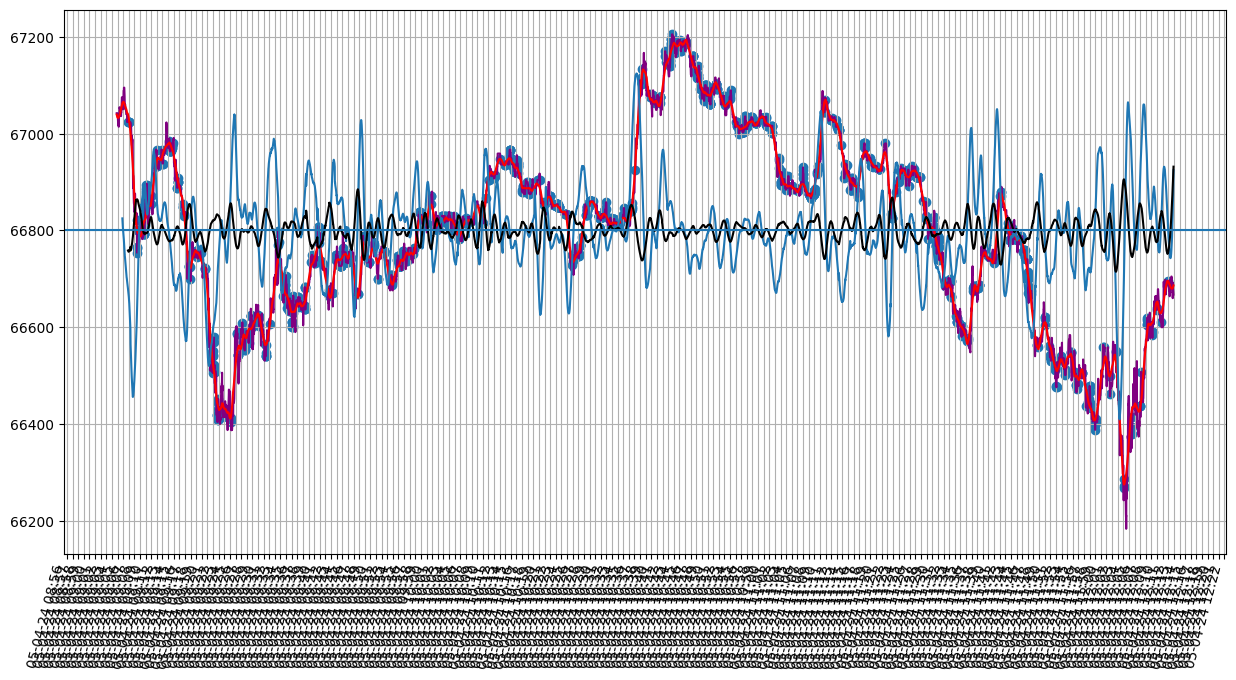

In [16]:
## Conexión con Binance para descargar la lista de pares que binance maneja
from binance import Client
client = Client()


##################################################################################################################################
# Descarga y limpieza de datos de 5 días en adelante
##################################################################################################################################

smooth_interval = 120
smooth_exp = 3

recent_data = pd.read_csv('../csvs/streaming/BTCUSDT.csv')
recent_data.columns = ['Tiempo','Par','Precio']
recent_data['Tiempo'] = recent_data.Tiempo.astype('datetime64')
recent_data = recent_data.set_index('Tiempo')
recent_data['Precio'] = recent_data.Precio.astype(float)
recent_data = recent_data.reset_index()
recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Precio,smooth_interval,smooth_exp)
recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,smooth_exp)
recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,smooth_exp)
# recent_data


##################################################################################################################################
# Gráfica final del backtesting sobre nuestro análisis con puntos de compra y venta.
##################################################################################################################################
a = 0
d = 50000

min_max_sd = pd.DataFrame(columns=['Derivada'])
min_max_sd['Derivada'] = recent_data[a:a+d].SD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
lista_min_max = min_max_sd[(min_max_sd['Derivada'] >= -0.00015) & (min_max_sd['Derivada'] <= 0.00015)]
lista_min_max = lista_min_max.index.tolist()

mp = recent_data.Precio[a:a+d].mean()
# plt.axvline(halving_dates['Halving_Dates'][2])
# plt.axvline(halving_dates['Halving_Dates'][3])
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[a:a+d],recent_data.Precio[a:a+d].multiply(1),color='purple')
plt.plot(recent_data.Tiempo[a:a+d],recent_data.Interpolacion[a:a+d].multiply(1),color='red')
plt.plot(recent_data.Tiempo[a:a+d],recent_data.PD_Interpolacion[a:a+d].multiply(100)+mp)
plt.plot(recent_data.Tiempo[a:a+d],recent_data.SD_Interpolacion[a:a+d].multiply(1000)+mp,color='k')
# for i in recent_data.Tiempo.iloc[lista_min_max]:
#     plt.axvline(i)
plt.scatter(recent_data.Tiempo.iloc[lista_min_max],recent_data.Precio.iloc[lista_min_max])
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
# plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gcf().autofmt_xdate()
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
# plt.axvline(6500)
plt.show

In [35]:
ratio_PD_SD = recent_data.PD_Interpolacion/recent_data.SD_Interpolacion
ratio_PD_SD.describe()

count     3639.000000
mean        -3.477001
std       1327.777522
min     -56677.937397
25%        -37.629542
50%          1.807297
75%         52.683215
max      28891.784353
dtype: float64